In [1]:
%matplotlib widget

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from copy import deepcopy as copy
from datetime import datetime

from astropy.table import Table, hstack
from astropy.time import Time
from skycalc_cli.skycalc import AlmanacQuery, SkyModel

from lvmdrp import log, path, __version__ as drpver
from lvmdrp.core.constants import SPEC_CHANNELS
from lvmdrp.core.rss import RSS
from lvmdrp.core.spectrum1d import Spectrum1D
from lvmdrp.core.sky import run_skycorr
from lvmdrp.utils import metadata as md

from lvmdrp.functions import rssMethod as rss_tasks
from lvmdrp.functions import imageMethod as image_tasks
from lvmdrp.functions import skyMethod as sky_tasks

In [2]:
mjd = 60148
tileid = 1111
expnum = 1717

In [3]:
sci_metadata = md.get_metadata(tileid=tileid, mjd=mjd, expnum=expnum).sort_values(["expnum", "camera"])
sci_metadata

[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60148/raw_metadata.hdf5
[INFO]: found 36 frames in store '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60148/raw_metadata.hdf5'
[INFO]: filtering by expnum = 1717
[INFO]: number of frames after filtering 9
[INFO]: total number of frames found 9


,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,xenon,argon,ldls,quartz,quality,qual,stage,status,drpqual,name
3,s,1111,60148,60148,object,sp1,b1,1717,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b1-00001717.fits
2,s,1111,60148,60148,object,sp2,b2,1717,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b2-00001717.fits
7,s,1111,60148,60148,object,sp3,b3,1717,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b3-00001717.fits
8,s,1111,60148,60148,object,sp1,r1,1717,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r1-00001717.fits
4,s,1111,60148,60148,object,sp2,r2,1717,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r2-00001717.fits
5,s,1111,60148,60148,object,sp3,r3,1717,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r3-00001717.fits
1,s,1111,60148,60148,object,sp1,z1,1717,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z1-00001717.fits
0,s,1111,60148,60148,object,sp2,z2,1717,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z2-00001717.fits
6,s,1111,60148,60148,object,sp3,z3,1717,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z3-00001717.fits


In [4]:
arc_lamps = {"b": "hgne", "r": "neon", "z": "neon"}

for sci in sci_metadata.to_dict("records"):
    if sci["camera"][0] != "z": continue
    
    # define sci paths
    sci_path = path.full("lvm_raw", camspec=sci["camera"], **sci)
    psci_path = path.full("lvm_anc", drpver=drpver, kind="p", imagetype=sci["imagetyp"], **sci)
    dsci_path = path.full("lvm_anc", drpver=drpver, kind="d", imagetype=sci["imagetyp"], **sci)
    xsci_path = path.full("lvm_anc", drpver=drpver, kind="x", imagetype=sci["imagetyp"], **sci)
    wsci_path = path.full("lvm_anc", drpver=drpver, kind="w", imagetype=sci["imagetyp"], **sci)
    # lamps configuration per spectrograph channel
    lamps = arc_lamps[sci["camera"][0]]
    
    # define calibration frames paths
    masters_path = os.getenv("LVM_MASTER_DIR")
    mpixmask_path = os.path.join(masters_path, f"lvm-mpixmask-{sci['camera']}.fits")
    mbias_path = os.path.join(masters_path, f"lvm-mbias-{sci['camera']}.fits")
    mdark_path = os.path.join(masters_path, f"lvm-mdark-{sci['camera']}.fits")
    mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{sci['camera']}.fits")
    mwave_path = os.path.join(masters_path, f"lvm-mwave_{lamps}-{sci['camera']}.fits")
    mlsf_path = os.path.join(masters_path, f"lvm-mlsf_{lamps}-{sci['camera']}.fits")
    mflat_path = os.path.join(masters_path, f"lvm-mfiberflat-{sci['camera']}.fits")
    
    break

In [5]:
# in_rss = wsci_path
# in_flat = mflat_path

# # load input RSS
# log.info(f"loading input RSS file '{os.path.basename(in_rss)}'")
# rss = RSS()
# rss.loadFitsData(in_rss)

# dlambda = np.diff(rss._wave, axis=1)
# dlambda = np.column_stack((dlambda, dlambda[:, -1]))
# dlambda

# # load flat field
# flat = RSS()
# flat.loadFitsData(in_flat)
# # create interpolating function
# # all_wave = np.repeat([flat._wave], 648, axis=0)
# # all_wave = flat._wave
# fiberflat = []
# for ifiber in range(flat._fibers):
#     flat_in = interpolate.interp1d(flat._wave, flat._data[ifiber], kind="linear", bounds_error=False, fill_value=np.nan)
#     fiberflat.append(flat_in(rss._wave[ifiber]))

# fiberflat = np.asarray(fiberflat)
# # interpolate flatfield in the original wavelength grid & apply to RSS
# # fiberflat = flat_in(rss._wave)
# # # fiberflat = interpv(rss._wave, flat._wave, flat._data, left=np.nan, right=np.nan)
# # rss._data = rss._data / fiberflat
# # rss._error = rss._error / fiberflat
# # # divide by the wavelength sampling step at each pixel
# # rss._data = rss._data / np.diff(rss._wave, axis=1, append=(rss._wave[-2] - rss._wave[-1]))
# # # interpolate flatfield in the original wavelength grid & apply to RSS

[INFO]: loading input RSS file 'lvm-wobject-z1-00001717.fits'
[INFO]: interpolating sky fibers for 'both' sky telescope(s)
[WARNING]: CUNIT = 'dimensionless'  (FITSFixedWarning)
[WARNING]: CUNIT = 'dimensionless'  (FITSFixedWarning)


ValueError: operands could not be broadcast together with shapes (40,4085) (40,) 

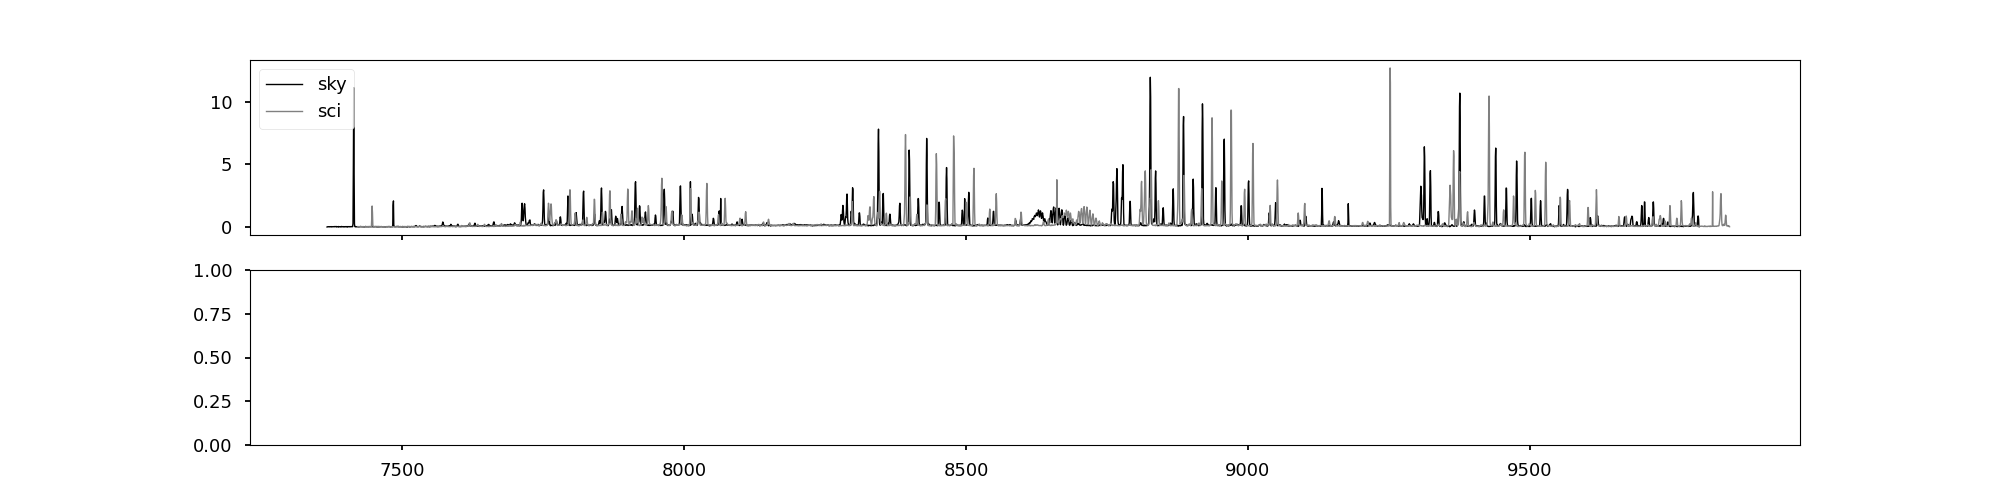

In [6]:
from importlib import reload

reload(sky_tasks)

f_data, f_error, sky_rss, swave, ssky, svars, smask = sky_tasks.interpolate_sky(in_rss=wsci_path, out_sky="test_sky.fits", out_rss="test_subsky.fits", in_flat=mflat_path, which="both", subtract=True, display_plots=True)

# iwave, fwave = SPEC_CHANNELS[sci["camera"][0]]
# rss_tasks.resample_wavelength(in_rss="test_subsky.fits", out_rss="test_subsky.fits", method="linear", disp_pix=0.5, start_wave=iwave, end_wave=fwave, err_sim=10, parallel=0, extrapolate=False)

In [7]:
in_sky = '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60148/ancillary/lvm-wsky_e-z1-00001717.fits'
in_rss = wsci_path
in_flat = mflat_path

# ifiber = 10

# load input RSS
# log.info(f"loading input RSS file '{os.path.basename(in_rss)}'")
rss = RSS()
rss.loadFitsData(in_rss)

rss_sky = RSS()
rss_sky.loadFitsData(in_sky)

flat = RSS()
flat.loadFitsData(in_flat)
# flat = flat.subRSS(sky_selection)
# # create interpolating function
# flat_in = interpolate.interp1d(flat._wave, flat._data, axis=1, kind="linear", bounds_error=False, fill_value=np.nan)
# # interpolate flatfield in the original wavelength grid & apply to RSS
# fiberflat = flat_in(rss._wave)
# interpolate fiberflat in the original wavelength grid & apply to RSS
# fiberflat = []
# for i in range(flat._fibers):
#     iflat = flat.getSpec(i)
#     new_flat = iflat.resampleSpec(rss._wave[i], err_sim=1, extrapolate=None)._data
#     fiberflat.append(new_flat)
#     # flat_in = interpolate.interp1d(flat._wave, flat._data[ifiber], kind="linear", bounds_error=False, fill_value=np.nan)
#     # fiberflat.append(flat_in(rss._wave[ifiber]))
# fiberflat = np.asarray(fiberflat)
fiberflat = flat._data

iwave, fwave = SPEC_CHANNELS[rss._header["CCD"][0]]
iwave, fwave = rss._wave.min(), rss._wave.max()
ref_wave = np.arange(iwave, fwave+0.5, 0.5)

new_sky, new_sci, sub_sci = [], [], []
for ifiber in range(rss._fibers):

    flat_spec = fiberflat[ifiber]

    sky_spec = rss_sky.getSpec(ifiber)
    sky_spec._mask = (~np.isfinite(sky_spec._data)) | (~np.isfinite(sky_spec._error))

    sci_spec = rss.getSpec(ifiber)
    sci_spec._mask = (~np.isfinite(sci_spec._data)) | (~np.isfinite(sci_spec._error))

    # new_sky = sky_spec.resampleSpec(ref_wave, method="linear", err_sim=10, extrapolate=None)

    old_dlambda = np.diff(sky_spec._wave, append=sky_spec._wave[-1])
    new_dlambda = interpolate.interp1d(ref_wave, np.diff(ref_wave, append=ref_wave[-1]), bounds_error=False)(sky_spec._wave)

    new_sky.append(sky_spec._data * 0.5 * flat_spec)
    new_sci.append(sci_spec._data)
    sub_sci.append(sci_spec._data - (sky_spec._data * 0.5 * flat_spec))
# old_dlambda = interpolate.interp1d(sky_spec._wave, np.diff(sky_spec._wave, append=sky_spec._wave[-1]), bounds_error=False)(ref_wave)
# new_dlambda = np.diff(ref_wave, append=ref_wave[-1]+0.5)
# f_data = interpolate.interp1d(sky_spec._wave, sky_spec._data, bounds_error=False, assume_sorted=True)
# f_error = interpolate.interp1d(sky_spec._wave, sky_spec._error ** 2, bounds_error=False, assume_sorted=True)
# f_mask = interpolate.interp1d(sky_spec._wave, sky_spec._error, fill_value=0, kind="nearest", bounds_error=False, assume_sorted=True)
# new_sky = Spectrum1D(wave=ref_wave, data=f_data(ref_wave), error=np.sqrt(f_error(ref_wave)), mask=f_mask(ref_wave).astype(bool))
# new_sky._data *= (old_dlambda / new_dlambda)
# new_sky._error *= (old_dlambda / new_dlambda)

# plt.plot(new_sky._wave, new_sky._data, lw=1, color="r")
# plt.show()

# sky_spec._data = np.nan_to_num(sky_spec._data, nan=0, posinf=0, neginf=0)
# new_sky._data = np.nan_to_num(new_sky._data, nan=0, posinf=0, neginf=0)
# print(np.trapz(sky_spec._data, sky_spec._wave), np.trapz(new_sky._data, new_sky._wave))

# rss_tasks.resample_wavelength(in_rss=in_rss, out_rss="test_resample.fits", method="linear", disp_pix=0.5, start_wave=iwave, end_wave=fwave, err_sim=10, parallel=6, extrapolate=False)

# rss_r = RSS()
# rss_r.loadFitsData("test_resample.fits")

[WARNING]: CUNIT = 'dimensionless'  (FITSFixedWarning)
[WARNING]: CUNIT = 'dimensionless'  (FITSFixedWarning)


In [8]:
RSS(data=np.asarray(new_sci), wave=ref_wave, mask=~np.isfinite(new_sci)).writeFitsData("new_sci.fits")
RSS(data=np.asarray(new_sky), wave=ref_wave, mask=~np.isfinite(new_sky)).writeFitsData("new_sky.fits")
RSS(data=np.asarray(sub_sci)/np.asarray(new_sky), wave=ref_wave, mask=~np.isfinite(sub_sci)).writeFitsData("sub_sci.fits")

[WARNING]: divide by zero encountered in divide (RuntimeWarning)
[WARNING]: invalid value encountered in divide (RuntimeWarning)


[WARNING]: divide by zero encountered in divide (RuntimeWarning)
[WARNING]: divide by zero encountered in divide (RuntimeWarning)


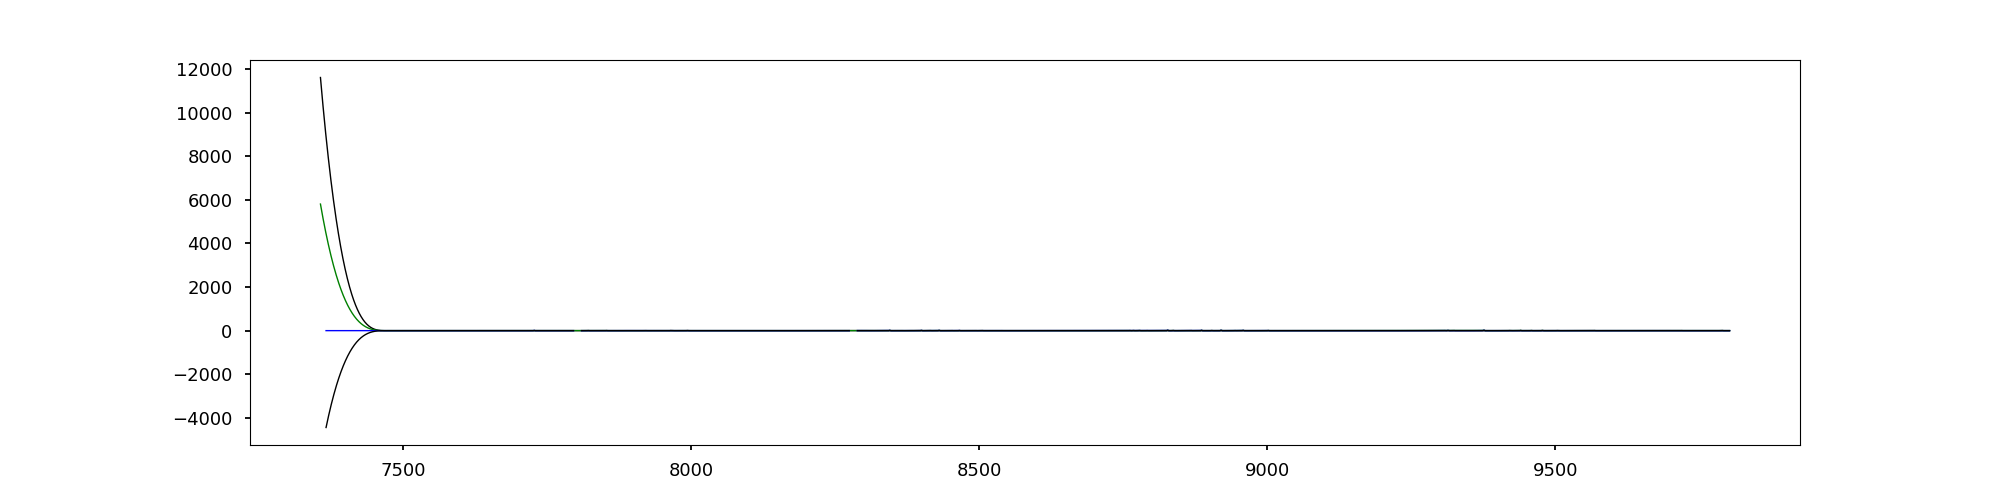

In [9]:
plt.figure(figsize=(20,5))
plt.plot(sky_spec._wave, sky_spec._data, lw=1, color="k")
plt.plot(sky_spec._wave, sky_spec._data * 0.5, lw=1, color="g")
# plt.plot(sci_spec._wave, sci_spec._data, lw=1, color="r")
plt.plot(sci_spec._wave, sci_spec._data / flat_spec, lw=1, color="b")
plt.plot(sky_spec._wave, sci_spec._data / flat_spec - sky_spec._data * 0.5, lw=1, color="k")

[WARNING]: divide by zero encountered in divide (RuntimeWarning)


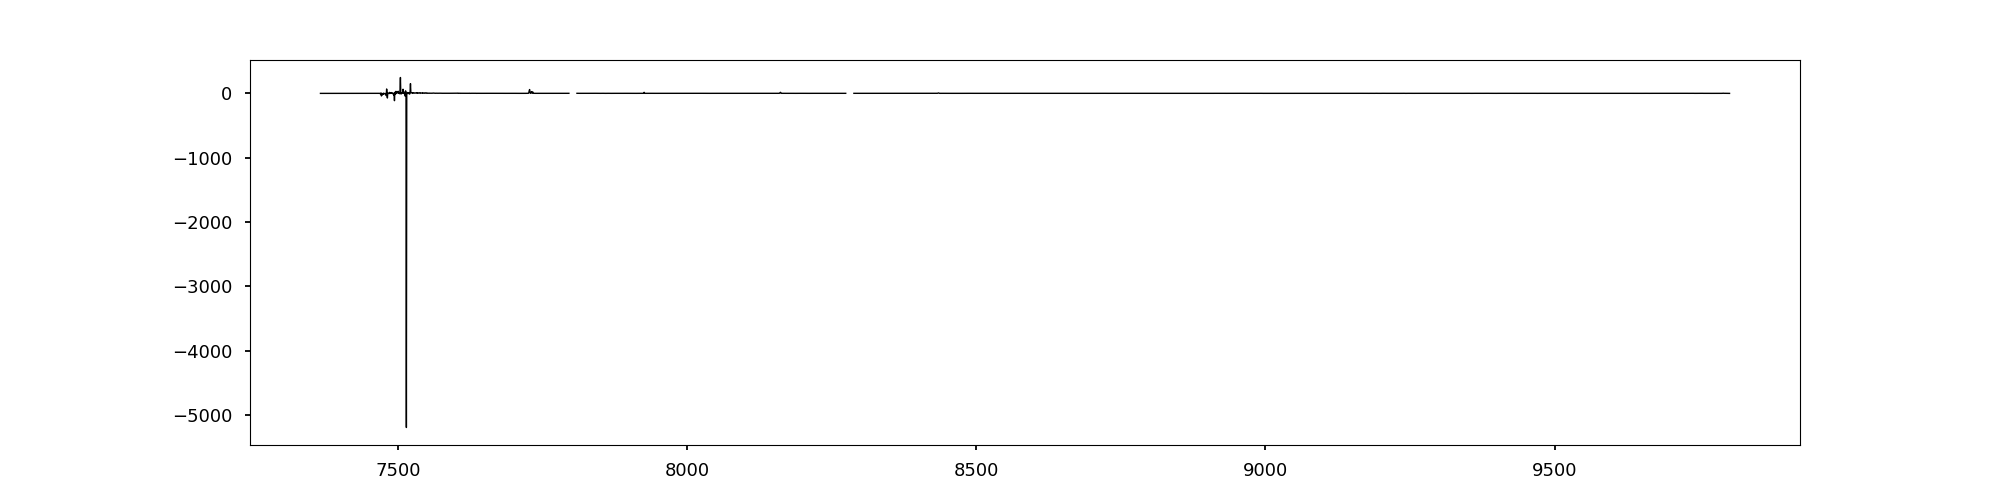

In [10]:
plt.figure(figsize=(20,5))
plt.plot(sky_spec._wave, (sci_spec._data / flat_spec - sky_spec._data * 0.5) / (sky_spec._data * 0.5), lw=1, color="k")
# plt.plot(sci_spec._wave, , lw=1, color="r")

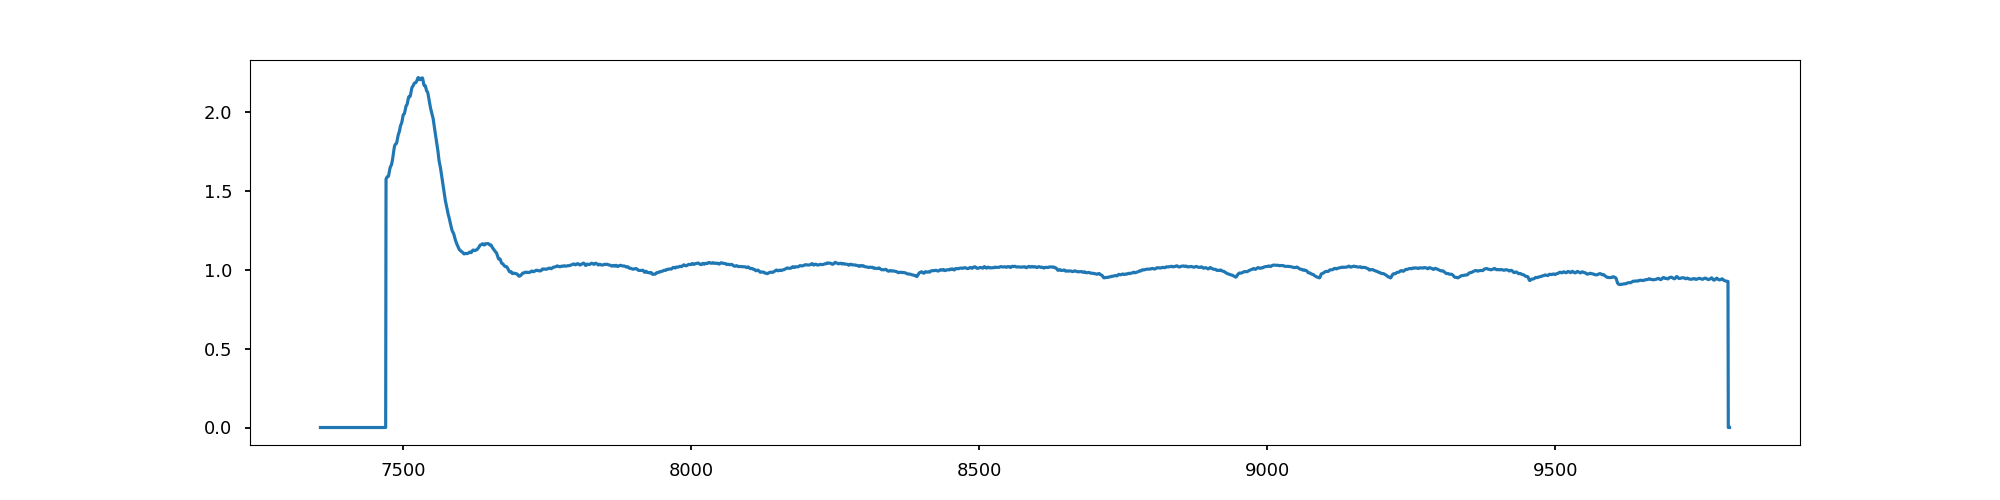

In [21]:
plt.figure(figsize=(20,5))
plt.plot(rss._wave[ifiber], flat_spec)

In [7]:
# from specutils import Spectrum1D
# from specutils.manipulation import FluxConservingResampler
# from astropy import units as u


# sky = RSS()
# sky.loadFitsData("test_sky.fits")
# ifiber = 319
# iwave, fwave = SPEC_CHANNELS[sky._header["CCD"][0]]

# hsky = []
# fluxc_resample = FluxConservingResampler()
# resample_grid = np.arange(iwave, fwave+0.5, 0.5)*u.angstrom
# for ifiber in range(sky._fibers):
#     input_spectra = Spectrum1D(
#         flux=sky._data[ifiber] * u.electron/u.s/u.angstrom,
#         spectral_axis=sky._wave[ifiber] * u.angstrom)
#     new_sky = fluxc_resample(input_spectra, resample_grid)
    
#     hsky.append(new_sky.data * 0.5)

# hsky = np.asarray(hsky)

# hrss = RSS()
# hrss.loadFitsData(wsci_path.replace("wobject", "hobject"))

# sub_sky = copy(hrss)
# sub_sky.setData(data=hrss._data - hsky)

# sub_sky.writeFitsData("test_subsky.fits")

In [13]:
# plt.figure(figsize=(25,5))
# plt.scatter(swave[~smask], np.sqrt(svars[~smask]), s=1)
# plt.plot(swave[~smask], np.sqrt(f_error(swave[~smask]) * svars[~smask]), color="k")